In [2]:
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.model_selection import cross_validate, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.utils import resample
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from scipy.stats import loguniform
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix

## read data 
CIP_data_no_drop = pd.read_csv("CIP_data_encode_prev_not_dropped.csv")

In [55]:
threshold_seq = np.linspace(0,1,101)
#for the prevalence, in the TB paper, they used the prevalence to flq in the whole dataset 
#so for us, think that would be 14%
#calculate prevalence of CIP resistance 
prevalence_CIPR = 1 - CIP_data_no_drop["Susceptible"].sum()/len(CIP_data_no_drop["Susceptible"])
print(1 - CIP_data_no_drop["Susceptible"].sum()/len(CIP_data_no_drop["Susceptible"]))

# need to use the threshold to get the senstivity and specificity of the model 
utility_results = []

### set up model 
model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 13, alpha = 1.291549665014884, random_state=10, learning_rate = 'constant' )
#train data: 2000 - 2010 
train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,2010])]
X_train = train_data[['MSM','MSMW', 'MSW','Northeast', 'Southeast', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC']]
y_train = train_data['Susceptible']

oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
X_train, y_train = oversample.fit_resample(X_train,y_train)


#test data: 2011 - 2019 
test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2011])]
X_test = test_data[['MSM','MSMW', 'MSW','Northeast', 'Southeast', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC']]
y_test = test_data['Susceptible']
cipro_R_prev_2011 = 1 - y_test.sum()/len(y_test) #get prevalence in 2011 before radndom oversampling
oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
X_test, y_test = oversample.fit_resample(X_test,y_test)

print(cipro_R_prev_2011)

model_fit_train = model_nn.fit(X_train, y_train)
y_predict_test = model_fit_train.predict(X_test)
y_predict_proba = model_fit_train.predict_proba(X_test)



0.14488785370753954
0.1328696925329429


In [56]:
correctly_get_X_threshold = []
incorrectly_get_X_threshold = [] #no bootstrapping, no 95% CI 

for threshold in threshold_seq:

  y_predict_test = np.where(y_predict_proba[:, 1] > threshold, 1, 0)

  tn_test , fp_test , fn_test , tp_test  = confusion_matrix(y_true=y_test, y_pred=y_predict_test).ravel()

  sensitivity_test  = tp_test  / (tp_test   + fn_test )
  specificity_test   = tn_test / (tn_test + fp_test )
  
  correctly_get_X_threshold.append(sensitivity_test * cipro_R_prev_2011 + (1 -  cipro_R_prev_2011)) #q_p
  incorrectly_get_X_threshold.append((1 - cipro_R_prev_2011) * (1 - specificity_test)) #c_p

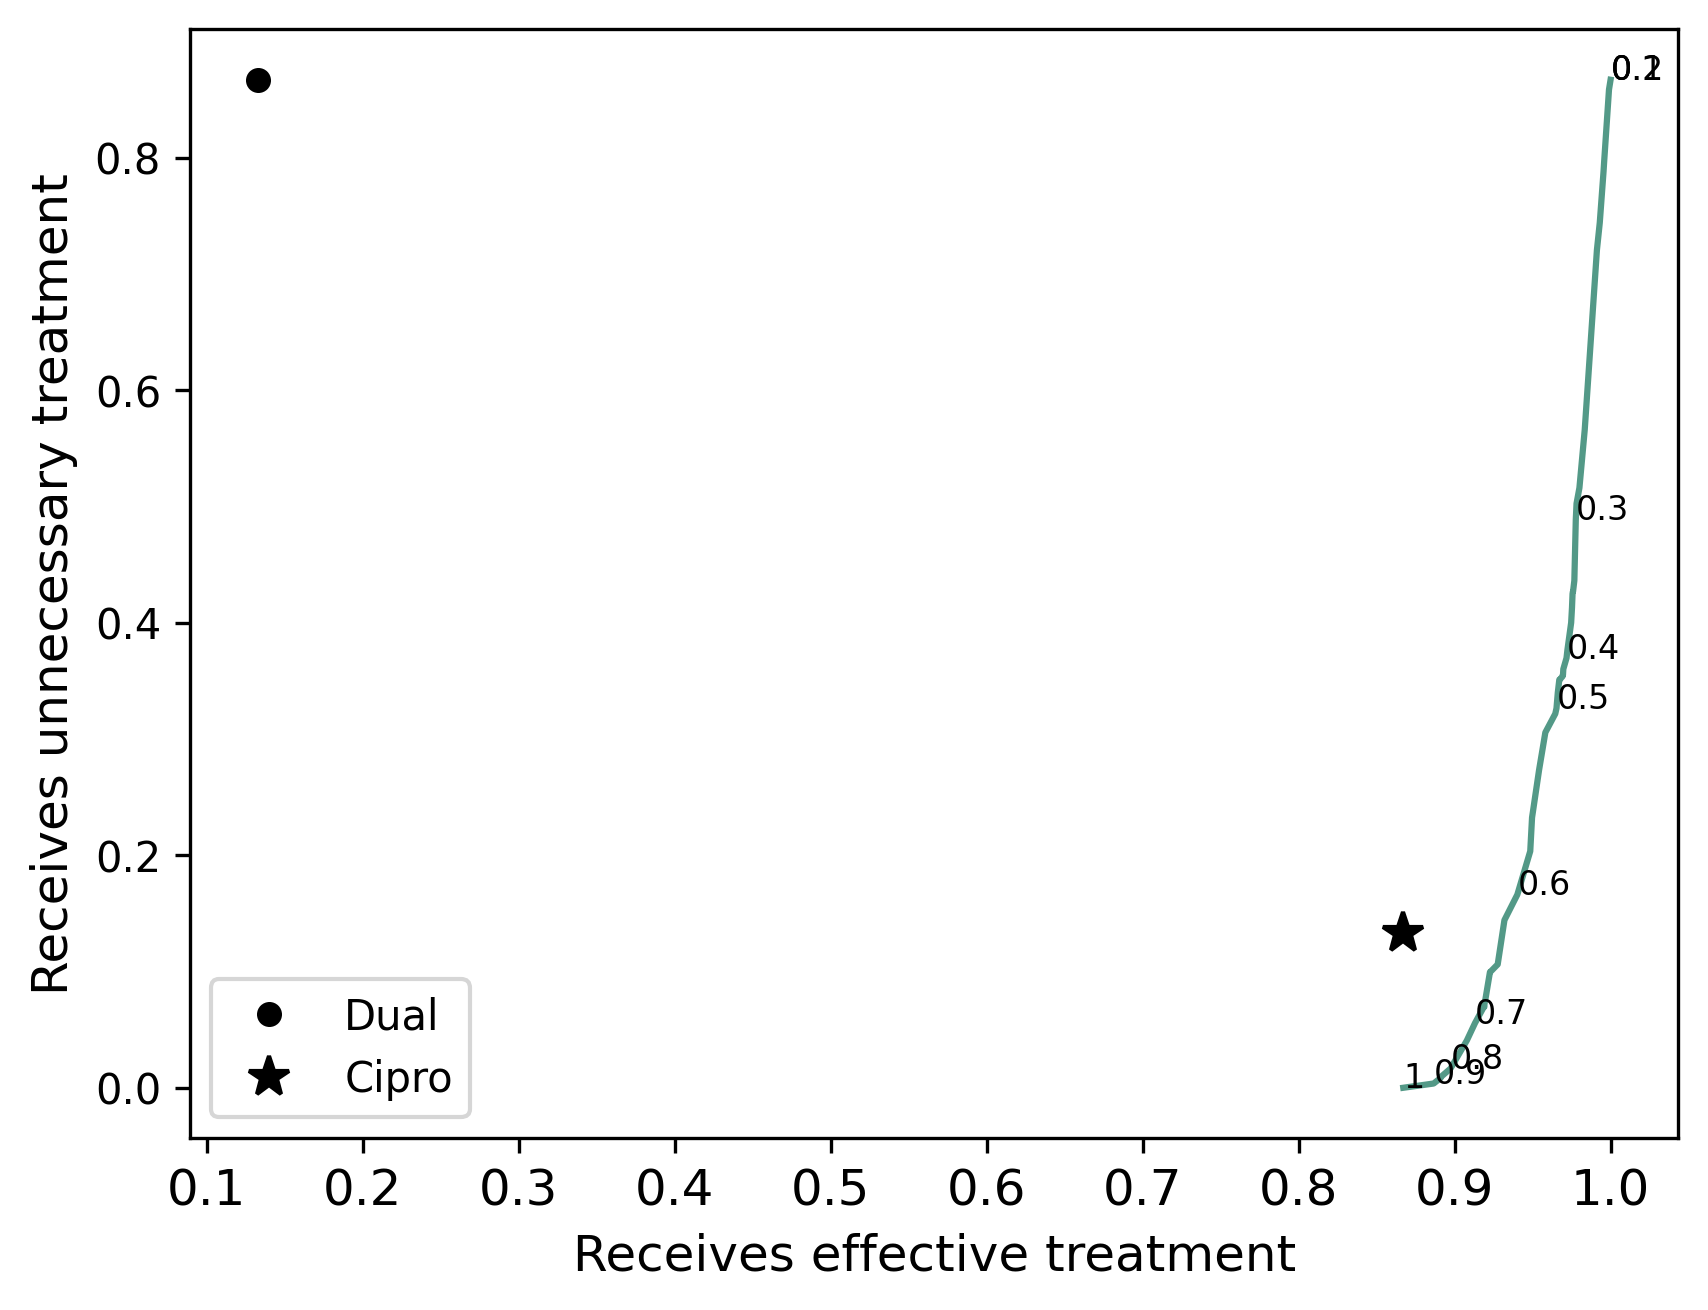

In [57]:


#this is only effective in that they are not getting CIPRO - could get another drug they actually cannot have 
## can we compare the "actual" proprtion that would receive the incorrect treatment with the porpor
## that 
plt.plot(correctly_get_X_threshold, incorrectly_get_X_threshold, color = "#539987")

plt.xlabel("Receives effective treatment", fontsize=12)
plt.ylabel("Receives unnecessary treatment", fontsize=12)
plt.xticks(np.linspace(0,1,11), fontsize=12)
plt.rcParams['figure.dpi'] = 300

plt.plot(cipro_R_prev_2011, 1 - cipro_R_prev_2011, marker='.', ls='none', ms=10, color = "black", label = "Dual")
plt.plot((1-cipro_R_prev_2011), cipro_R_prev_2011, marker='*', ls='none', ms=10, color = "black", label = "Cipro")
#plt.plot([0], correctly_get_X_threshold[0], marker='*', ls='none', ms=10, color = "black", label = "Dual")
plt.legend()
text_for_graph = ['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1']
indices = [0,10,20,30,40,50,60,70,80,90,100]
x = 0
for index in indices:
    plt.text(correctly_get_X_threshold[index], incorrectly_get_X_threshold[index], text_for_graph[x], size = 8)
    x = x+1

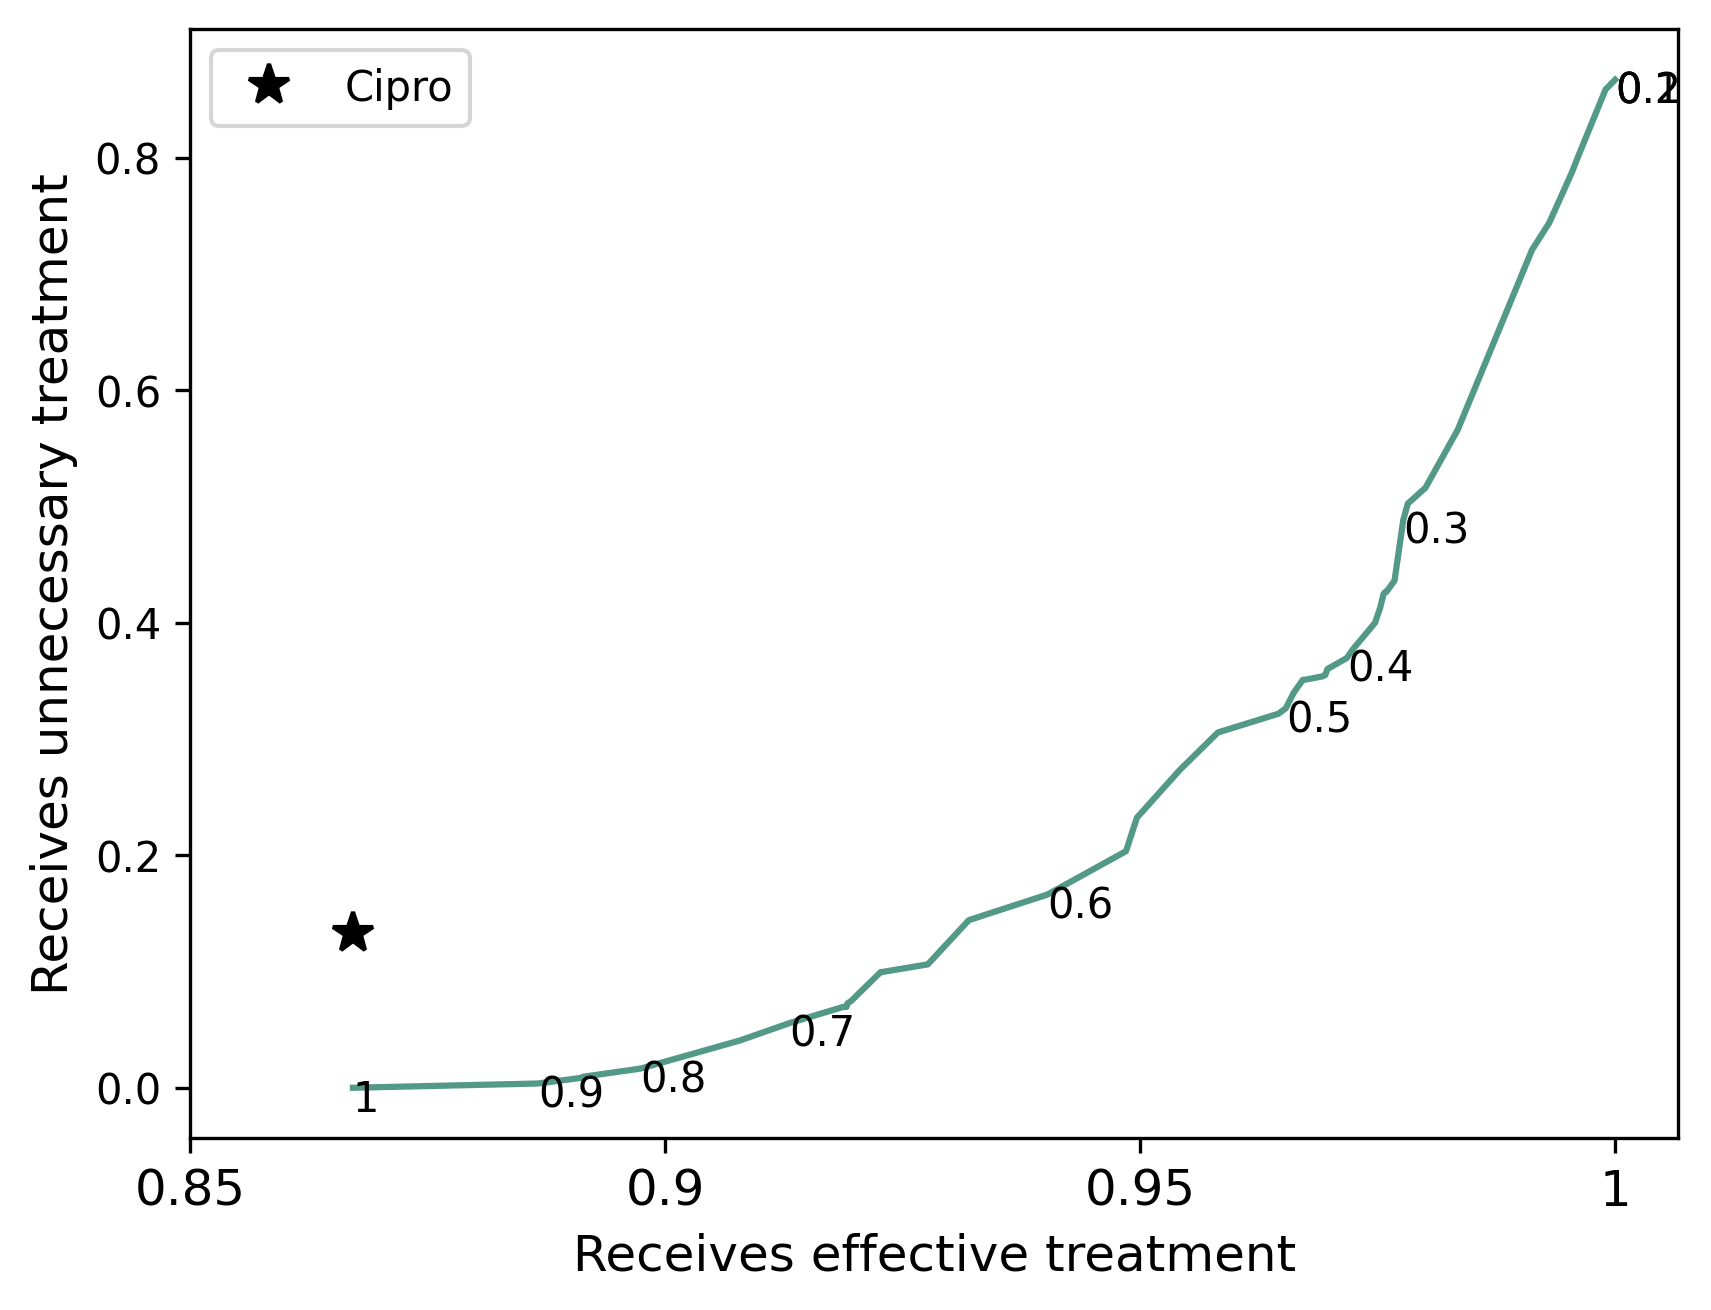

In [58]:

plt.plot(correctly_get_X_threshold, incorrectly_get_X_threshold, color = "#539987")

plt.xlabel("Receives effective treatment", fontsize=12)
plt.ylabel("Receives unnecessary treatment", fontsize=12)
plt.xticks((0.85, 0.9, 0.95, 1), ['0.85', '0.9', '0.95', '1'], fontsize=12)
plt.rcParams['figure.dpi'] = 300
plt.xlim(left = 0.85)
plt.plot((1-cipro_R_prev_2011), cipro_R_prev_2011, marker='*', ls='none', ms=10, color = "black", label = "Cipro")
#pt.plot([0], correctly_get_X_threshold[0], marker='*', ls='none', ms=10, color = "black", label = "Dual")
plt.legend()
text_for_graph = ['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1']
indices = [0,10,20,30,40,50,60,70,80,90,100]
x = 0
for index in indices:
    plt.text(correctly_get_X_threshold[index], incorrectly_get_X_threshold[index]- 0.02, text_for_graph[x])
    x = x+1



0.14488785370753954
0.1328696925329429


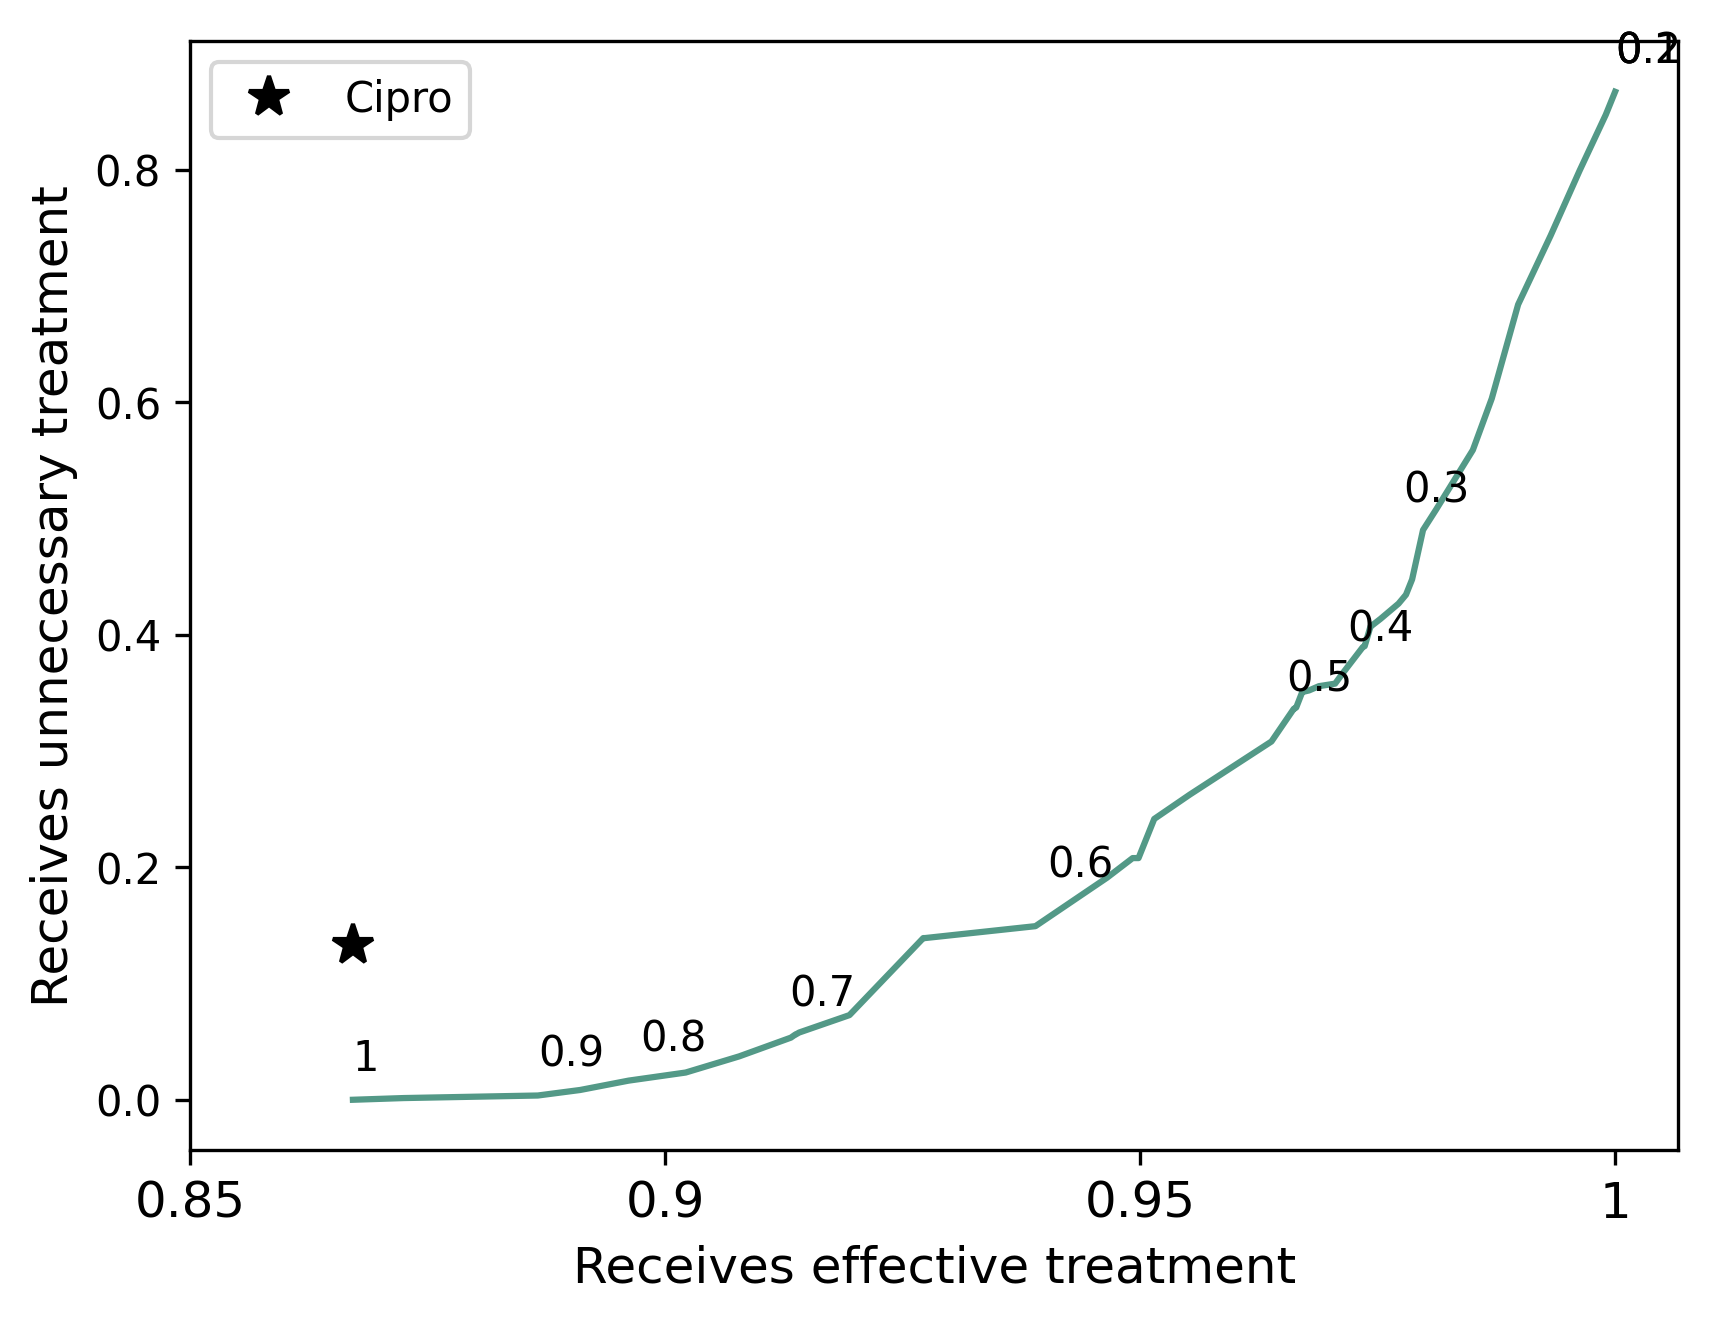

In [59]:
####### What happens if you limit to the previous 5 years
threshold_seq = np.linspace(0,1,101)
#for the prevalence, in the TB paper, they used the prevalence to flq in the whole dataset 
#so for us, think that would be 14%
#calculate prevalence of CIP resistance 
prevalence_CIPR = 1 - CIP_data_no_drop["Susceptible"].sum()/len(CIP_data_no_drop["Susceptible"])
print(1 - CIP_data_no_drop["Susceptible"].sum()/len(CIP_data_no_drop["Susceptible"]))

# need to use the threshold to get the senstivity and specificity of the model 
utility_results = []

### set up model 
model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 13, alpha = 1.291549665014884, random_state=10, learning_rate = 'constant' )
#train data: 2000 - 2010 
train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([ 2006, 2007, 2008, 2009,2010])]
X_train = train_data[['MSM','MSMW', 'MSW','Northeast', 'Southeast', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC']]
y_train = train_data['Susceptible']

oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
X_train, y_train = oversample.fit_resample(X_train,y_train)


#test data: 2011 - 2019 
test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2011])]
X_test = test_data[['MSM','MSMW', 'MSW','Northeast', 'Southeast', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC']]
y_test = test_data['Susceptible']
cipro_R_prev_2011 = 1 - y_test.sum()/len(y_test) #get prevalence in 2011 before radndom oversampling
oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
X_test, y_test = oversample.fit_resample(X_test,y_test)

print(cipro_R_prev_2011)

model_fit_train = model_nn.fit(X_train, y_train)
y_predict_test = model_fit_train.predict(X_test)
y_predict_proba = model_fit_train.predict_proba(X_test)

correctly_get_X_threshold_prev_5 = []
incorrectly_get_X_threshold_prev_5 = [] #no bootstrapping, no 95% CI 

for threshold in threshold_seq:

  y_predict_test = np.where(y_predict_proba[:, 1] > threshold, 1, 0)

  tn_test , fp_test , fn_test , tp_test  = confusion_matrix(y_true=y_test, y_pred=y_predict_test).ravel()

  sensitivity_test  = tp_test  / (tp_test   + fn_test )
  specificity_test   = tn_test / (tn_test + fp_test )
  
  correctly_get_X_threshold_prev_5.append(sensitivity_test * cipro_R_prev_2011 + (1 -  cipro_R_prev_2011)) #q_p
  incorrectly_get_X_threshold_prev_5.append((1 - cipro_R_prev_2011) * (1 - specificity_test)) #c_p

## can we compare the "actual" proprtion that would receive the incorrect treatment with the porpor
## that 
plt.plot(correctly_get_X_threshold_prev_5, incorrectly_get_X_threshold_prev_5, color = "#539987")

plt.xlabel("Receives effective treatment", fontsize=12)
plt.ylabel("Receives unnecessary treatment", fontsize=12)
plt.xticks((0.85, 0.9, 0.95, 1), ['0.85', '0.9', '0.95', '1'], fontsize=12)
plt.rcParams['figure.dpi'] = 300
plt.xlim(left = 0.85)
#plt.plot(cipro_R_prev_2011, 1 - cipro_R_prev_2011, marker='.', ls='none', ms=10, color = "black", label = "Dual")
plt.plot((1-cipro_R_prev_2011), cipro_R_prev_2011, marker='*', ls='none', ms=10, color = "black", label = "Cipro")
#plt.plot([0], correctly_get_X_threshold[0], marker='*', ls='none', ms=10, color = "black", label = "Dual")
plt.legend()
text_for_graph = ['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1']
indices = [0,10,20,30,40,50,60,70,80,90,100]
x = 0
for index in indices:
    plt.text(correctly_get_X_threshold[index], incorrectly_get_X_threshold[index] + 0.025, text_for_graph[x])
    x = x+1

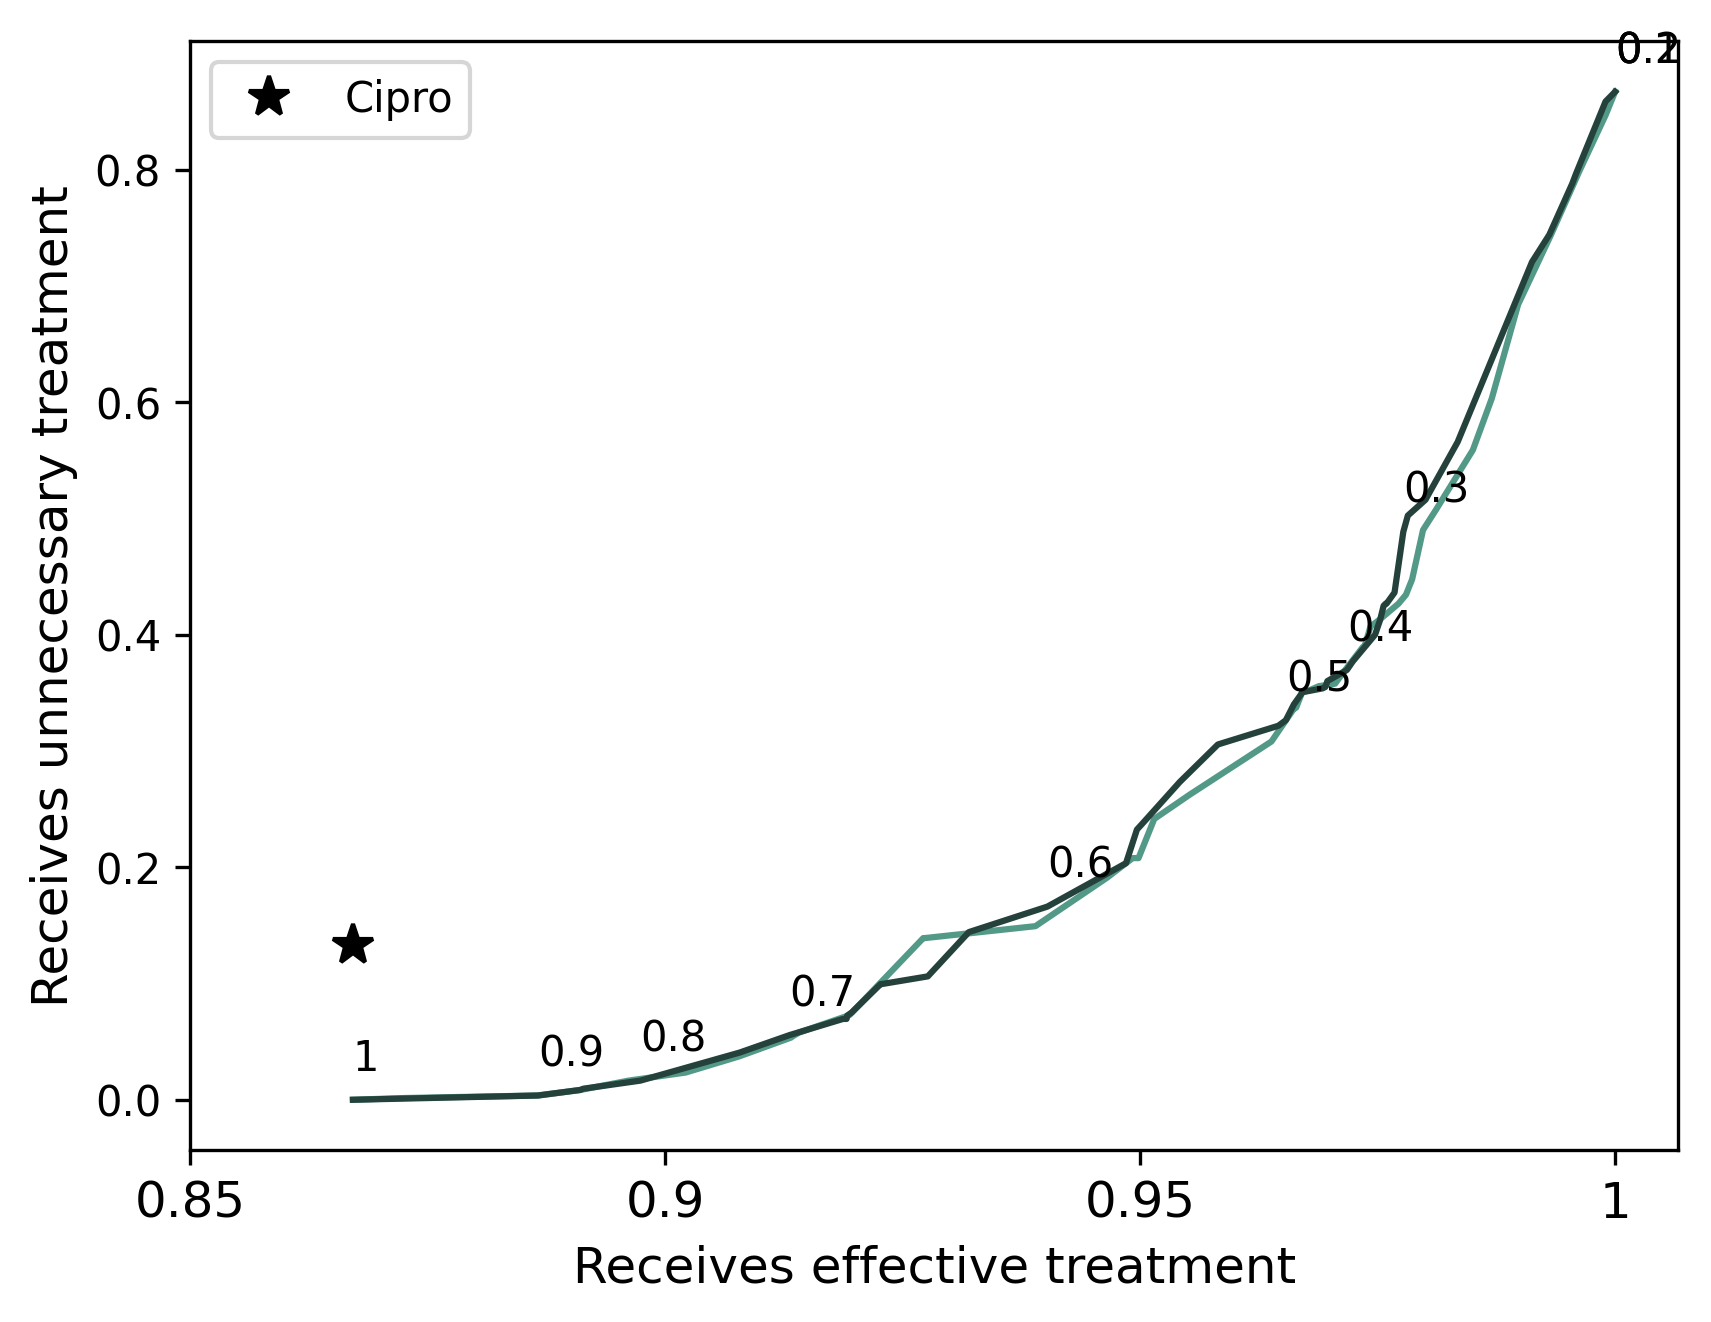

In [60]:
plt.plot(correctly_get_X_threshold_prev_5, incorrectly_get_X_threshold_prev_5, color = "#539987")
plt.plot(correctly_get_X_threshold, incorrectly_get_X_threshold, color = "#24423B")

plt.xlabel("Receives effective treatment", fontsize=12)
plt.ylabel("Receives unnecessary treatment", fontsize=12)
plt.xticks((0.85, 0.9, 0.95, 1), ['0.85', '0.9', '0.95', '1'], fontsize=12)
plt.rcParams['figure.dpi'] = 300
plt.xlim(left = 0.85)
#plt.plot(cipro_R_prev_2011, 1 - cipro_R_prev_2011, marker='.', ls='none', ms=10, color = "black", label = "Dual")
plt.plot((1-cipro_R_prev_2011), cipro_R_prev_2011, marker='*', ls='none', ms=10, color = "black", label = "Cipro")
#plt.plot([0], correctly_get_X_threshold[0], marker='*', ls='none', ms=10, color = "black", label = "Dual")
plt.legend()
text_for_graph = ['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1']
indices = [0,10,20,30,40,50,60,70,80,90,100]
x = 0
for index in indices:
    plt.text(correctly_get_X_threshold[index], incorrectly_get_X_threshold[index] + 0.025, text_for_graph[x])
    x = x+1

0.14488785370753954
0.14760080277321652


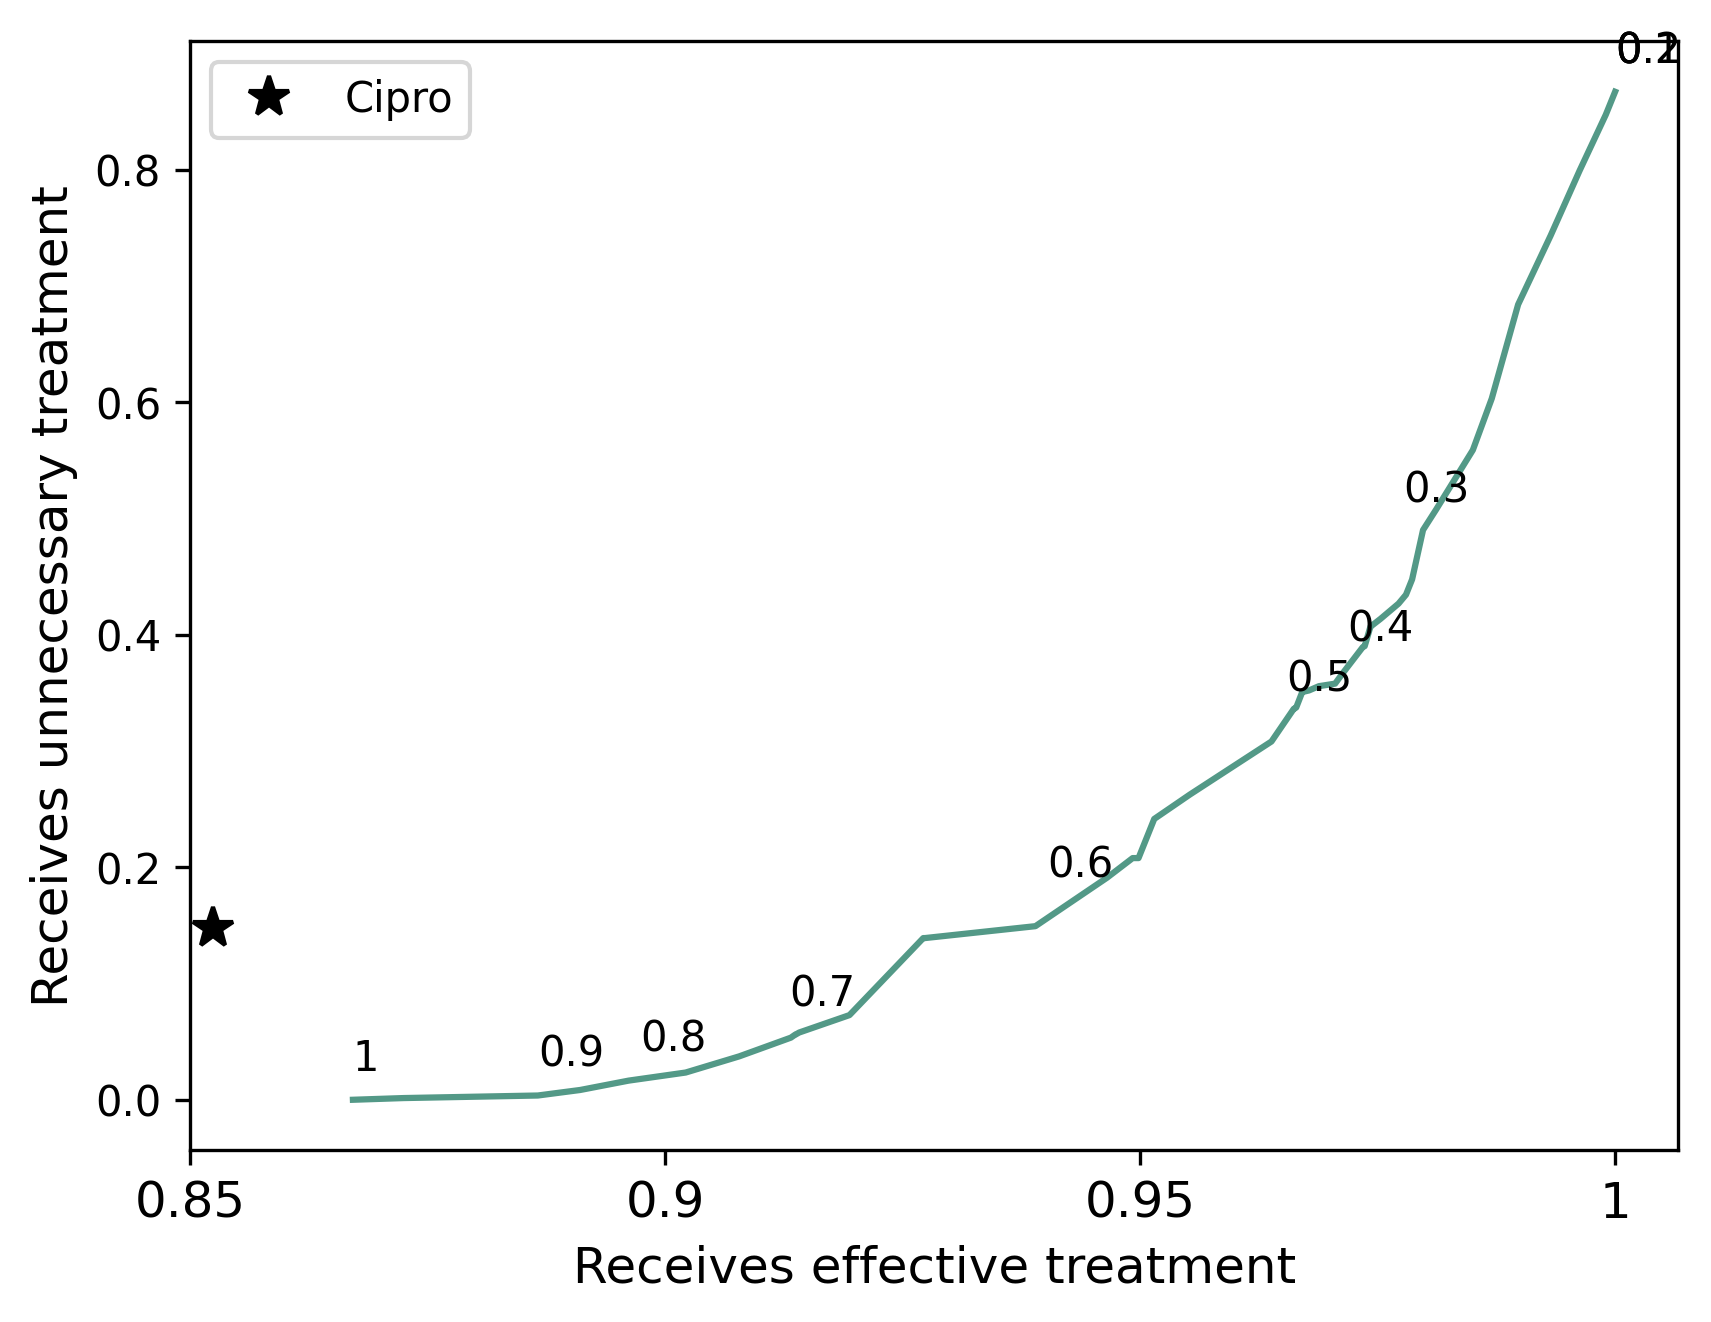

In [62]:
####### What happens if you limit to the previous 5 years
threshold_seq = np.linspace(0,1,101)
#for the prevalence, in the TB paper, they used the prevalence to flq in the whole dataset 
#so for us, think that would be 14%
#calculate prevalence of CIP resistance 
prevalence_CIPR = 1 - CIP_data_no_drop["Susceptible"].sum()/len(CIP_data_no_drop["Susceptible"])
print(1 - CIP_data_no_drop["Susceptible"].sum()/len(CIP_data_no_drop["Susceptible"]))

# need to use the threshold to get the senstivity and specificity of the model 
utility_results = []

### set up model 
model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 13, alpha = 1.291549665014884, random_state=10, learning_rate = 'constant' )
#train data: 2000 - 2010 
train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,2010, 2011])]
X_train = train_data[['MSM','MSMW', 'MSW','Northeast', 'Southeast', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC']]
y_train = train_data['Susceptible']

oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
X_train, y_train = oversample.fit_resample(X_train,y_train)


#test data: 2011 - 2019 
test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2012])]
X_test = test_data[['MSM','MSMW', 'MSW','Northeast', 'Southeast', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC']]
y_test = test_data['Susceptible']
cipro_R_prev_2012 = 1 - y_test.sum()/len(y_test) #get prevalence in 2011 before radndom oversampling
oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
X_test, y_test = oversample.fit_resample(X_test,y_test)

print(cipro_R_prev_2012)

model_fit_train = model_nn.fit(X_train, y_train)
y_predict_test = model_fit_train.predict(X_test)
y_predict_proba = model_fit_train.predict_proba(X_test)

correctly_get_X_threshold_2012 = []
incorrectly_get_X_threshold_2012 = [] #no bootstrapping, no 95% CI 

for threshold in threshold_seq:

  y_predict_test = np.where(y_predict_proba[:, 1] > threshold, 1, 0)

  tn_test , fp_test , fn_test , tp_test  = confusion_matrix(y_true=y_test, y_pred=y_predict_test).ravel()

  sensitivity_test  = tp_test  / (tp_test   + fn_test )
  specificity_test   = tn_test / (tn_test + fp_test )
  
  correctly_get_X_threshold_2012.append(sensitivity_test * cipro_R_prev_2012 + (1 -  cipro_R_prev_2012)) #q_p
  incorrectly_get_X_threshold_2012.append((1 - cipro_R_prev_2012) * (1 - specificity_test)) #c_p

## can we compare the "actual" proprtion that would receive the incorrect treatment with the porpor
## that 
plt.plot(correctly_get_X_threshold_prev_5, incorrectly_get_X_threshold_prev_5, color = "#539987")

plt.xlabel("Receives effective treatment", fontsize=12)
plt.ylabel("Receives unnecessary treatment", fontsize=12)
plt.xticks((0.85, 0.9, 0.95, 1), ['0.85', '0.9', '0.95', '1'], fontsize=12)
plt.rcParams['figure.dpi'] = 300
plt.xlim(left = 0.85)
#plt.plot(cipro_R_prev_2011, 1 - cipro_R_prev_2011, marker='.', ls='none', ms=10, color = "black", label = "Dual")
plt.plot((1-cipro_R_prev_2012), cipro_R_prev_2012, marker='*', ls='none', ms=10, color = "black", label = "Cipro")
#plt.plot([0], correctly_get_X_threshold[0], marker='*', ls='none', ms=10, color = "black", label = "Dual")
plt.legend()
text_for_graph = ['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1']
indices = [0,10,20,30,40,50,60,70,80,90,100]
x = 0
for index in indices:
    plt.text(correctly_get_X_threshold[index], incorrectly_get_X_threshold[index] + 0.025, text_for_graph[x])
    x = x+1